## Setup evnironment

In [24]:
import mvranalysis as mvr
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json

## Setup plotting

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')

## Load trial data

In [84]:
path = '/Volumes/freeman/Nick/mVR/sessions/000114'
session = mvr.load_session(path)

In [85]:
maze = mvr.loadMazeMat(path+'/behavior')

OneChoiceRLcts.mat


In [86]:
#session.to_csv(path + '/behavior/session.csv')

#### Create trial summary

In [87]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())

In [88]:
#Returns table of all trials and whether or not they entered a specific branch
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep
 

## Plot data

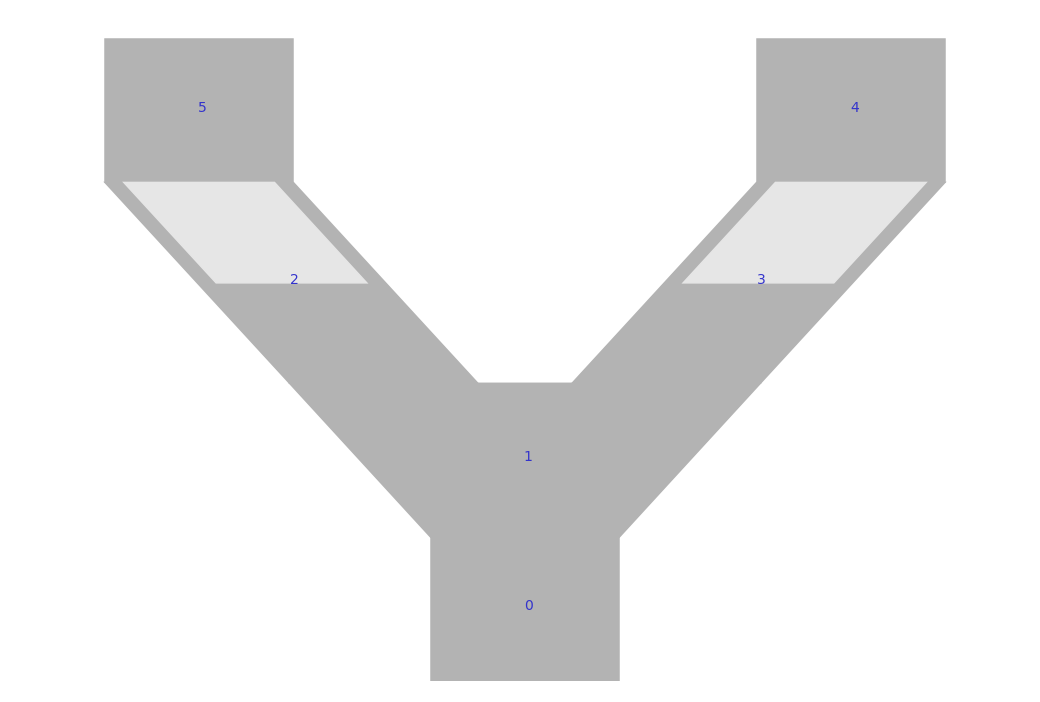

In [89]:
plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)

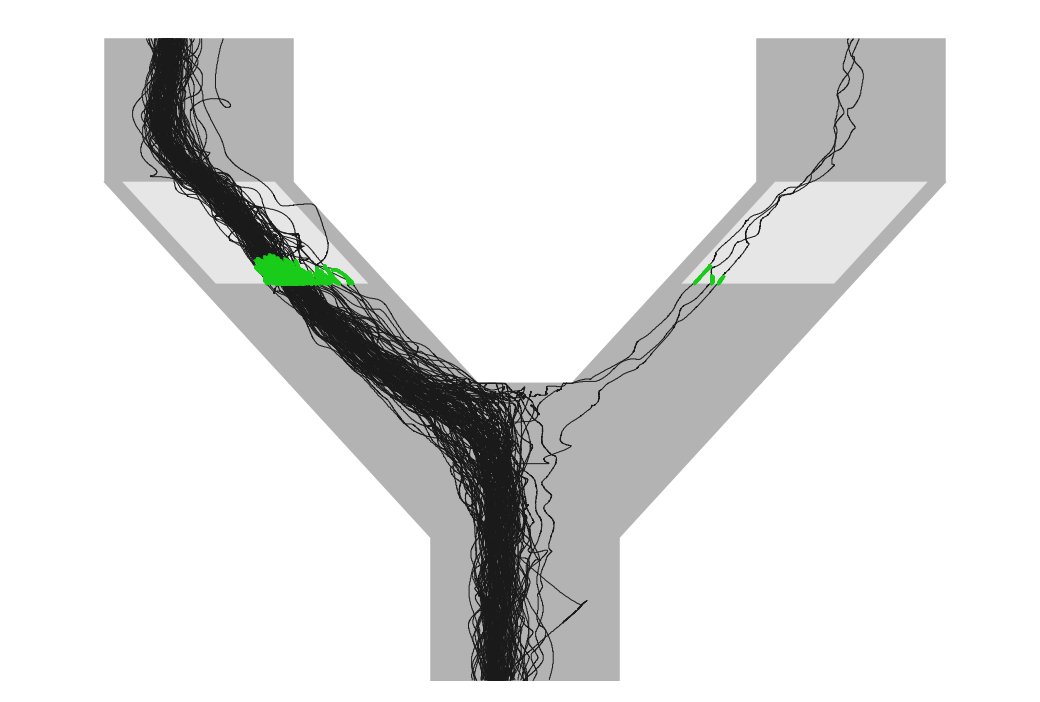

In [90]:
plt.figure(figsize=[18,12])
Id = 0
keep = trial[trial.trialType == Id].index.tolist()
mvr.draw(maze[Id],False)
mvr.trace(session, keep, [0.1, 0.1, 0.1])
#mvr.licks(session, keep, [0.9, 0.1, 0.1])
mvr.water(session, keep, [0.1, 0.8, 0.1])

3
0
0
128


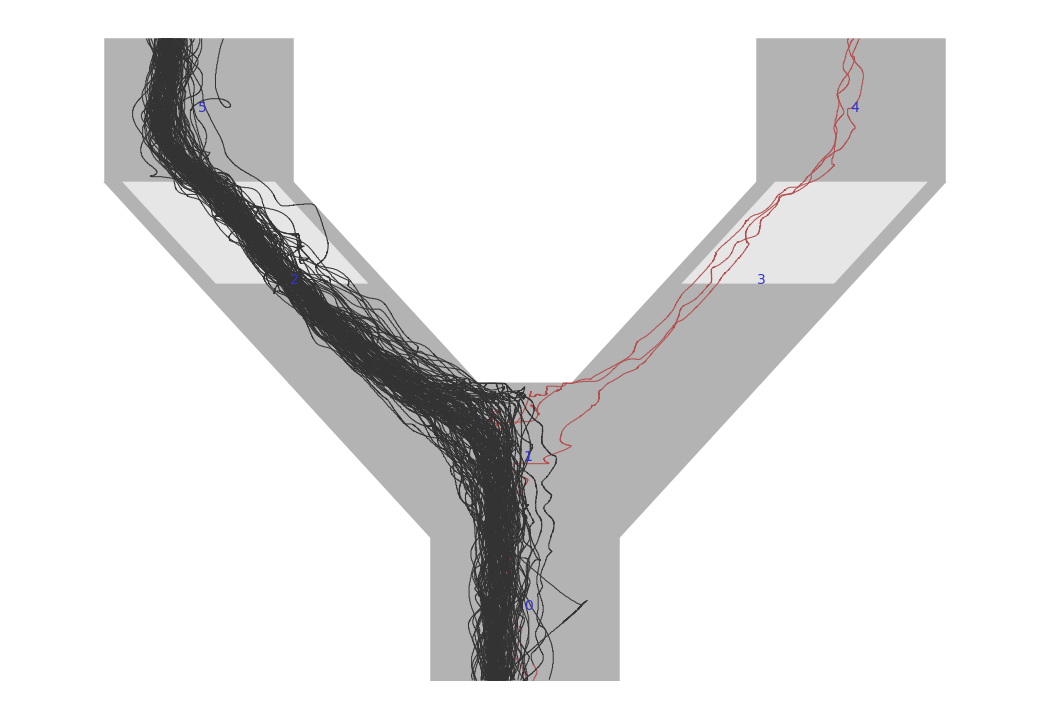

In [91]:
#For the unbiased maze 

plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)
branchId = 3
keepW = trialEntered(branchId)
branchId = 4
keepE = trialEntered(branchId)
branchId = 2
keepS = trialEntered(branchId)
branchId = 5
keepN = trialEntered(branchId)

keepR = trial[(keepS.curBranchId == False) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepR)
mvr.trace(session, keepR, [0.7, 0.3, 0.3]) #chose right

keepRL = trial[(keepW.curBranchId == True) & (keepN.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepRL)
mvr.trace(session, keepRL, [0.3, 0.7, 0.3]) #init choice right, exited left

keepLR = trial[(keepS.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepLR)
mvr.trace(session, keepLR, [0.4, 0.5, 0.2]) #init choice left, exited right

keepL = trial[(keepW.curBranchId == False) & (keepN.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepL)
mvr.trace(session, keepL, [0.2, 0.2, 0.2]) #chose left

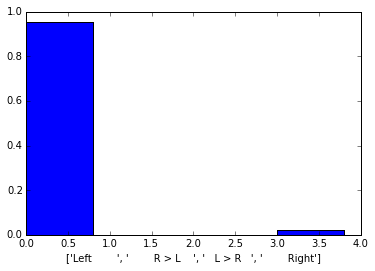

In [92]:
classified = [len(keepL), len(keepRL), len(keepLR),len(keepR)]
numtrls = len(trial)
classified = [x / float(numtrls) for x in classified]
plt.bar(range(0,len(classified)),classified)
plt.xlabel(['Left        ', '        R > L    ','   L > R   ', '        Right'])

In [93]:
#Total bias split, based on initial choices

percent_left = (len(keepL)+len(keepLR))/float(numtrls)
percent_right = (len(keepR)+len(keepRL))/float(numtrls)

print percent_left,percent_right

0.955223880597 0.0223880597015


# Create dot plot

([<matplotlib.axis.YTick at 0x1095f1a10>,
 <a list of 2 Text yticklabel objects>)

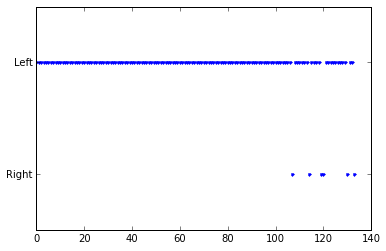

In [94]:
plt.plot(trialEntered(5),'.')
plt.ylim((-0.5,1.5))
plt.yticks([0,1],['Right', 'Left'])
#final trajectories, dead end or nah

In [95]:
#Classified into array

def init_choice(numtrials):    
    choices = ["" for x in range(numtrials)]

    for x in range(len(choices)):
        if x in keepR:
            choices[x] = "R"
        elif x in keepRL:
            choices[x] = "RL"
        elif x in keepLR:
            choices[x] = "LR"
        else:
            choices[x] = "L"
    return choices
choices = init_choice(numtrls)
print len(trial)
print len(choices)
trial ['Trajectory'] = choices
trial['initChoice']   = [x[:1] for x in choices] 


134
134


In [96]:
#Total bias split, based on initial choices

percent_left = (len(keepL)+len(keepLR))/float(numtrls)
percent_right = (len(keepR)+len(keepRL))/float(numtrls)
percent_qswitch = (len(keepRL) +len(keepLR))/float(numtrls)

print percent_left,percent_right, percent_qswitch

0.955223880597 0.0223880597015 0.0


In [97]:
def completion(session, numtrials):
    finish = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        if (stop-start) > 119:
            entry = False
        else:
            entry = True
        finish.append(entry)
    return finish

complete = completion(session,numtrls)
trial['Completed'] = complete
print trial.Completed

number
0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
       ...  
104     True
105     True
106     True
107     True
108     True
109     True
110     True
111     True
112     True
113     True
114    False
115     True
116     True
117     True
118     True
119     True
120    False
121     True
122     True
123     True
124     True
125     True
126     True
127     True
128     True
129     True
130    False
131     True
132     True
133     True
Name: Completed, dtype: bool


In [98]:
def trial_time(session, numtrials):
    seconds = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        seconds.append(stop-start)
    return seconds    
        
times = trial_time(session,numtrls)

trial['time'] = times

In [99]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    
    for n in range(numtrials):
        start1 = session[session.number==n].time[session.curBranchId == choicept].min()
        stop1 = session[session.number==n].time[session.curBranchId == choicept].max()
        start0 = session[session.number==n].time[session.curBranchId == entrance].min()
        stop0 = session[session.number==n].time[session.curBranchId == entrance].max()
        think.append(stop1-start1)
        straight.append(stop0-start0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeChoice'] = t_choosing
trial['timeStraight'] = t_straight

In [100]:
newfolder = path+'/summary'

In [101]:
os.mkdir(newfolder)

In [102]:
trial.to_csv(newfolder+ '/trial_summary114.csv')